In [1]:
import os
import sys

## Using this Notebook
Before running this example, make sure that the **Python module of OpenSn** was installed.

### Converting and Running this Notebook from the Terminal
To run this notebook from the terminal, simply type:

`jupyter nbconvert --to python --execute problem_one.ipynb`.

To run this notebook in parallel (for example, using 4 processes), simply type:

`mpiexec -n 4 jupyter nbconvert --to python --execute problem_1.ipynb`.

In [2]:
from mpi4py import MPI
size = MPI.COMM_WORLD.size
rank = MPI.COMM_WORLD.rank

if rank == 0:
    print(f"Running the first LBS example with {size} MPI processors.")

Running the first LBS example with 1 MPI processors.


## Import Requirements

Import required classes and functions from the Python interface of OpenSn. Make sure that the path
to PyOpenSn is appended to Python's PATH.

In [3]:
# assuming that the execute dir is the notebook dir
# this line is not necessary when PyOpenSn is installed using pip
# sys.path.append("../../../..")

from pyopensn.mesh import FromFileMeshGenerator, PETScGraphPartitioner
from pyopensn.xs import MultiGroupXS
from pyopensn.source import VolumetricSource
from pyopensn.aquad import GLCProductQuadrature3DXYZ
from pyopensn.solver import DiscreteOrdinatesProblem, SteadyStateSolver, DiscreteOrdinatesCurvilinearProblem
from pyopensn.diffusion import DFEMDiffusionSolver
from pyopensn.fieldfunc import FieldFunctionInterpolationVolume, FieldFunctionGridBased
from pyopensn.context import UseColor, Finalize
from pyopensn.logvol import SphereLogicalVolume, BooleanLogicalVolume, RPPLogicalVolume
from pyopensn.math import Vector3, ScalarSpatialMaterialFunction
import numpy as np
import math

OpenSn version 0.0.1
2025-05-10 17:19:03 Running OpenSn with 1 processes.



In [4]:
import matplotlib.pyplot as plt

In [20]:
from scipy.special import exp1
from scipy.integrate import quad

##### Disable colorized output.

In [5]:
UseColor(False)

In [6]:
meshgen = FromFileMeshGenerator(
    filename="./vtk_meshes/two_spheres.msh",
    partitioner=PETScGraphPartitioner(type='parmetis'),
)
grid = meshgen.Execute()

[0]  FromFileMeshGenerator: Generating UnpartitionedMesh
[0]  Making unpartitioned mesh from Gmsh file ./vtk_meshes/two_spheres.msh (format v2.2)
[0]  Mesh identified as 3D.
[0]  Done checking cell-center-to-face orientations
[0]  00:00:02.3 Establishing cell connectivity.
[0]  00:00:02.3 Vertex cell subscriptions complete.
[0]  00:00:02.4 Surpassing cell 2014 of 20138 (10%)
[0]  00:00:02.5 Surpassing cell 4028 of 20138 (20%)
[0]  00:00:02.5 Surpassing cell 6042 of 20138 (30%)
[0]  00:00:02.6 Surpassing cell 8056 of 20138 (40%)
[0]  00:00:02.6 Surpassing cell 10069 of 20138 (50%)
[0]  00:00:02.7 Surpassing cell 12083 of 20138 (60%)
[0]  00:00:02.7 Surpassing cell 14097 of 20138 (70%)
[0]  00:00:02.7 Surpassing cell 16111 of 20138 (80%)
[0]  00:00:02.8 Surpassing cell 18125 of 20138 (90%)
[0]  00:00:02.8 Surpassing cell 20138 of 20138 (100%)
[0]  00:00:02.8 Establishing cell boundary connectivity.
[0]  00:00:02.8 Done establishing cell connectivity.
[0]  Done processing ./vtk_meshes/two

In [7]:
grid.SetUniformBlockID(0)

[0]  00:00:05.8 Done setting block id 0 to all cells


In [8]:
def mat_id_function(pt, cur_id):
    if ((pt.x ** 2 + pt.y ** 2 + pt.z ** 2) ** (1/2)) <= 0.5:
        return 1
    return cur_id

In [9]:
grid.SetBlockIDFromFunction(mat_id_function)

In [10]:
grid.ExportToPVTU("problem_two_BlockIDs")

[0]  Exporting mesh to VTK files with base problem_two_BlockIDs
[0]  Done exporting mesh to VTK.


In [11]:
xs_mat = MultiGroupXS()
xs_mat.CreateSimpleOneGroup(sigma_t=1.,c=0.0)
xs_void = MultiGroupXS()
xs_void.CreateSimpleOneGroup(sigma_t=0.,c=0.0)
xs_src = MultiGroupXS()
xs_src.CreateSimpleOneGroup(sigma_t=0.,c=0.0)

[0]  *** WARNING ***  Negative transport cross section found for group 0 in call to ComputeDiffusionParameters. sigma_t=0 sigma_1=0. Setting sigma_1=0, sigma_tr=sigma_t for this group.
[0]  *** WARNING ***  Negative transport cross section found for group 0 in call to ComputeDiffusionParameters. sigma_t=0 sigma_1=0. Setting sigma_1=0, sigma_tr=sigma_t for this group.


In [13]:
mg_src = VolumetricSource(block_ids=[1], group_strength=[1.])

In [14]:
nazimu = 4
npolar = 2
pquad = GLCProductQuadrature3DXYZ(npolar, nazimu)

In [15]:
phys = DiscreteOrdinatesProblem(
    mesh=grid,
    num_groups=1,
    groupsets=[
        {
            "groups_from_to": (0, 0),
            "angular_quadrature": pquad,
            "angle_aggregation_type": "single",
            "angle_aggregation_num_subsets": 1,
            "inner_linear_method": "petsc_gmres",
            "l_abs_tol": 1.0e-6,
            "l_max_its": 300,
            "gmres_restart_interval": 30
        }
    ],
    options={
        "scattering_order": 0,
        "volumetric_sources": [mg_src],
        "boundary_conditions": [
            {"name":"xmin", "type":"vacuum"},
            {"name":"xmax", "type":"vacuum"},
            {"name":"ymin", "type":"vacuum"},
            {"name":"ymax", "type":"vacuum"},
            {"name":"zmin", "type":"vacuum"},
            {"name":"zmax", "type":"vacuum"}
        ]
    },
    xs_map=[
        {
            "block_ids": [0],
            "xs": xs_void
        },
        {
            "block_ids": [1],
            "xs": xs_mat
        }
    ]
)

In [16]:
ss_solver = SteadyStateSolver(lbs_problem=phys)
ss_solver.Initialize()
ss_solver.Execute()

[0]  
[0]  Initializing LBS SteadyStateSolver with name: LBSDiscreteOrdinatesProblem
[0]  
[0]  Scattering order    : 0
[0]  Number of Groups    : 1
[0]  Number of Group sets: 1
[0]  
[0]  ***** Groupset 0 *****
[0]  Groups:
[0]      0 
[0]  
[0]  Initializing spatial discretization.
[0]  Computing unit integrals.
[0]  Ghost cell unit cell-matrix ratio: 0%
[0]  Cell matrices computed.
[0]  Initializing parallel arrays. G=1 M=1
[0]  Done with parallel arrays.
[0]  Volumetric source #0 has 2572 total subscribing cells.
[0]  00:00:18.7 Initializing sweep datastructures.
[0]  00:00:20.0 Done initializing sweep datastructures.
[0]  00:00:20.0 Initialized angle aggregation.
[0]  Initializing WGS and AGS solvers
[0]  
[0]  
[0]  ********** Solving groupset 0 with PETSC_GMRES.
[0]  
[0]  Quadrature number of angles: 8
[0]  Groups 0 0
[0]  
[0]  Total number of angular unknowns: 644416
[0]  Number of lagged angular unknowns: 0(0%)
[0]  00:00:20.0 Computing b
[0]  00:00:20.4 WGS groups [0-0] Ite

In [17]:
fflist = phys.GetFieldFunctions()

[0]  Exporting field functions to VTK with file base "problem_two"
[0]  Done exporting field functions to VTK.


In [18]:
def average_vol(vol0, r1, r2):
    ffvol = FieldFunctionInterpolationVolume()
    ffvol.SetOperationType("avg")
    ffvol.SetLogicalVolume(vol0)
    ffvol.AddFieldFunction(fflist[0])
    ffvol.Initialize()
    ffvol.Execute()
    avgval = ffvol.GetValue()
    print("Radius: {:.2f} {:.2f} {:.6f}".format(r1, r2, avgval))
    return avgval

def create_vols(N_vols, rmax):
    r_vals = np.linspace(0, rmax, N_vols + 1)
    vols = np.empty(N_vols)
    avgphi = np.zeros(N_vols)
    for i in range(N_vols):
        if i != 0:
            inner_vol = SphereLogicalVolume(r=r_vals[i])
            outer_vol = SphereLogicalVolume(r=r_vals[i + 1])
            vol = BooleanLogicalVolume(parts=[{"op":True,"lv":outer_vol},{"op":False,"lv":inner_vol}])
        else:
            vol = SphereLogicalVolume(r=r_vals[i + 1])
        avgphi[i] = average_vol(vol, r_vals[i], r_vals[i+1])
    return avgphi

In [19]:
n_vols = 10
sim_vals = create_vols(n_vols, 1)

Radius: 0.00 0.10 0.387302
Radius: 0.10 0.20 0.376227
Radius: 0.20 0.30 0.354956
Radius: 0.30 0.40 0.317888
Radius: 0.40 0.50 0.248414
Radius: 0.50 0.60 0.123342
Radius: 0.60 0.70 0.078449
Radius: 0.70 0.80 0.057310
Radius: 0.80 0.90 0.045196
Radius: 0.90 1.00 0.035120


In [21]:
def E2(x):
    return np.exp(-x)-x*exp1(x)

def get_phi(r, q, a, sig):
    if r <= a:
        phi = q*(2-(1/(2*r))*((np.exp(-sig*(a-r))-np.exp(-sig*(a+r)))/sig \
                +(a+r)*E2(sig*(a-r))-(a-r)*E2(sig*(a+r))))
    else:
        a2 = a**2
        r2 = r**2
        phi = q*((1-(1-(a2/r2))**(1/2))-quad(lambda x: math.exp(-2*sig*(a2-r2*(1-x**2))**(1/2)),(1-a2/r2)**(1/2),1)[0])
    return phi        

In [23]:
q = 0.5
a = 0.5
sig = 1.
r_vals = np.linspace(0.05, 0.95, n_vols)
phi = np.zeros(n_vols)
for i in range(n_vols):
    phi[i] = get_phi(r_vals[i], q, a, sig)
    print(r_vals[i], phi[i])

0.05 0.3922024034167433
0.15 0.38181724989871335
0.25 0.35954591208865505
0.35 0.32123130115139287
0.44999999999999996 0.25392546815639194
0.5499999999999999 0.12780685218327742
0.65 0.08206068304231076
0.75 0.058634325321072184
0.85 0.04434796701494855
0.95 0.03484636764845568


In [24]:
err = np.zeros(n_vols)
err[:] = 100*abs(phi[:]-sim_vals[:])/phi[:]
print(err)

[1.2495198  1.46407547 1.27665468 1.04065425 2.17063083 3.49369088
 4.40117983 2.25841348 1.91285871 0.78512678]


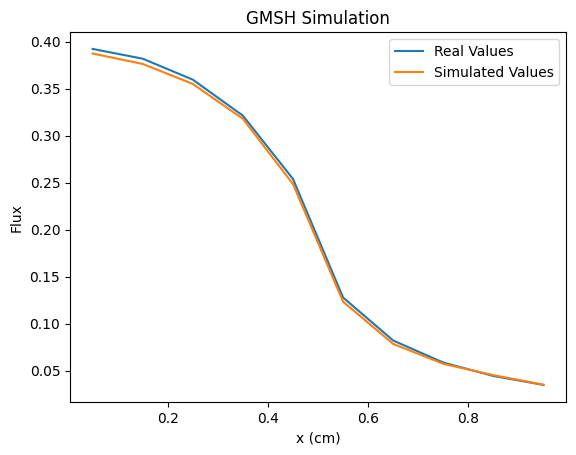

In [25]:
plt.figure(1)
plt.plot(r_vals,phi)
plt.plot(r_vals,sim_vals)
plt.title("GMSH Simulation")
plt.xlabel("x (cm)")
plt.ylabel("Flux") 
plt.legend(["Real Values", "Simulated Values"])
plt.show()

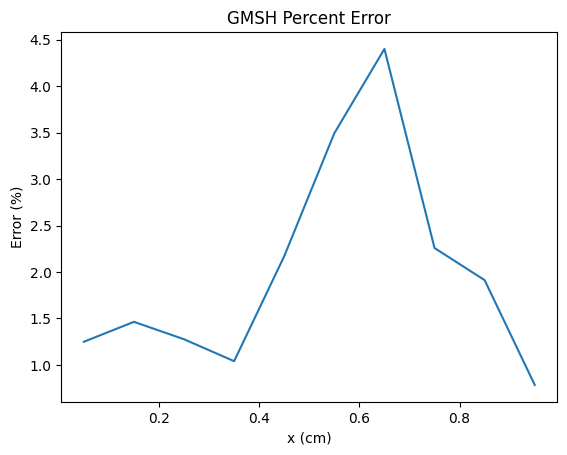

In [26]:
plt.figure(2)
plt.plot(r_vals,err)
plt.title("GMSH Percent Error")
plt.ylabel("Error (%)")
plt.xlabel("x (cm)")
plt.show()

## Finalize (for Jupyter Notebook only)

In Python script mode, PyOpenSn automatically handles environment termination. However, this
automatic finalization does not occur when running in a Jupyter notebook, so explicit finalization
of the environment at the end of the notebook is required. Do not call the finalization in Python
script mode, or in console mode.

Note that PyOpenSn's finalization must be called before MPI's finalization.


In [27]:
from IPython import get_ipython

def finalize_env():
    Finalize()
    MPI.Finalize()

ipython_instance = get_ipython()
if ipython_instance is not None:
    ipython_instance.events.register("post_execute", finalize_env)


Elapsed execution time: 00:04:03.0
2025-05-10 15:43:02 OpenSn finished execution.
